# Road Follower - Train Model

In this notebook we will train a neural network to take an input image, and output a set of x, y values corresponding to a target.

We will be using PyTorch deep learning framework to train ResNet18 neural network architecture model for road follower application.

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np
from ignite.handlers import ModelCheckpoint

### Download and extract data

Before you start, you should upload the ``road_following_<Date&Time>.zip`` file that you created in the ``data_collection.ipynb`` notebook on the robot. 

> If you're training on the JetBot you collected data on, you can skip this!

You should then extract this dataset by calling the command below:

In [ ]:
!unzip -q road_following.zip

In [2]:
def pre_process_pil_image(image_path, image):
    x = float(get_x(os.path.basename(image_path)))
    y = float(get_y(os.path.basename(image_path)))

    color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
    image = color_jitter(image)
    image = transforms.functional.resize(image, (224, 224))
    image = transforms.functional.to_tensor(image)
    image = image.numpy()[::-1].copy()
    image = torch.from_numpy(image)
    image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    return image, torch.tensor([x, y]).float()

### Create Dataset Instance

Here we create a custom ``torch.utils.data.Dataset`` implementation, which implements the ``__len__`` and ``__getitem__`` functions.  This class
is responsible for loading images and parsing the x, y values from the image filenames.  Because we implement the ``torch.utils.data.Dataset`` class,
we can use all of the torch data utilities :)

We hard coded some transformations (like color jitter) into our dataset.  We made random horizontal flips optional (in case you want to follow a non-symmetric path, like a road
where we need to 'stay right').  If it doesn't matter whether your robot follows some convention, you could enable flips to augment the dataset.

In [3]:
def get_x(path):
    """Gets the x value from the image filename"""
    return (float(int(path[3:6])) - 50.0) / 50.0

def get_y(path):
    """Gets the y value from the image filename"""
    return (float(int(path[7:10])) - 50.0) / 50.0

image_paths = glob.glob(os.path.join('dataset_xy', '*.jpg'))

import matplotlib.pyplot as plt
from PIL import Image


augmented_dataset = []
for image_path in image_paths:
    original_image = PIL.Image.open(image_path)
    brightness_enhancer = PIL.ImageEnhance.Brightness(original_image)
#     mode_image = original_image.filter(PIL.ImageFilter.ModeFilter(5))        
#     blurred_image = original_image.filter(PIL.ImageFilter.GaussianBlur(5))   
#     sharp_image = original_image.filter(PIL.ImageFilter.UnsharpMask(7))   
#     enhanced_image = original_image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE())
    dark_image = brightness_enhancer.enhance(0.4)
#     bright_image = brightness_enhancer.enhance(3)

    augmented_dataset.append(pre_process_pil_image(image_path, original_image))            
#     augmented_dataset.append(pre_process_pil_image(image_path, mode_image))
    augmented_dataset.append(pre_process_pil_image(image_path, dark_image))
#     augmented_dataset.append(pre_process_pil_image(image_path, bright_image))


In [4]:
len(augmented_dataset)

1124

In [5]:
len(image_paths)

562

### Split dataset into train and test sets
Once we read dataset, we will split data set in train and test sets. In this example we split train and test a 90%-10%. The test set will be used to verify the accuracy of the model we train.

In [7]:
test_percent = 0.3
num_test = int(test_percent * len(augmented_dataset))
train_dataset, test_dataset = torch.utils.data.random_split(augmented_dataset, [len(augmented_dataset) - num_test, num_test])

### Create data loaders to load data in batches

We use ``DataLoader`` class to load data in batches, shuffle data and allow using multi-subprocesses. In this example we use batch size of 64. Batch size will be based on memory available with your GPU and it can impact accuracy of the model.

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4 # Only one worker to work around windows10 bug!
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4 # Only one worker to work around windows10 bug!
)

### Define Neural Network Model 

We use ResNet-18 model available on PyTorch TorchVision. 

In a process called transfer learning, we can repurpose a pre-trained model (trained on millions of images) for a new task that has possibly much less data available.


More details on ResNet-18 : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

More Details on Transfer Learning: https://www.youtube.com/watch?v=yofjFQddwHE 

In [ ]:
model = models.resnet18(pretrained=False, progress=True)

ResNet model has fully connect (fc) final layer with 512 as ``in_features`` and we will be training for regression thus ``out_features`` as 1

Finally, we transfer our model for execution on the GPU

In [ ]:
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

<span style="font-family: Arial; font-size:1.4em;color:blue;">The restnet model layers</span>

In [ ]:
for idx, m in enumerate(model.modules()):
    print(idx, '->', m)

### Train Regression:

We train for 50 epochs and save best model if the loss is reduced. 

In [ ]:
NUM_EPOCHS = 1
BEST_MODEL_PATH = 'best_augmented_steering_model_xy_1.pth'
optimizer = optim.Adam(model.parameters())

import time

print('Statring training ....')
val_loss_total = np.array([])
loss_total = np.array([])
best_loss = 1e9

total = 0

train_accuracy = 0.0
validation_accuracy = 0.0
equality = 0.0
test_loss = 0.0
train_accuracy = 0.0

since = time.time()

# def accuracy_quick(model, data_x, data_y):
#     # calling code must set mode = 'train' or 'eval'
#     X = T.Tensor(data_x)
#     Y = T.LongTensor(data_y)
#     oupt = model(X)
#     (max_vals, arg_maxs) = T.max(oupt.data, dim=1) 
#     # arg_maxs is tensor of indices [0, 1, 0, 2, 1, 1 . . ]
#     num_correct = T.sum(Y==arg_maxs)
#     acc = (num_correct * 100.0 / len(data_y))
#     return acc.item()  # percentage based


# def accuracy(true,pred):
#     acc = (true.max(-1) == pred.max(-1)).float().detach().numpy()
#     return float(100 * acc.sum() / len(acc))

for epoch in range(NUM_EPOCHS):
    print('Epoch {}/{}'.format(epoch, NUM_EPOCHS - 1))
    print('-' * 10)
    
    model.train()
    train_loss = 0.0
#     train_accuracy = 0.0
    
#     running_loss = 0.0
    running_corrects = 0
    
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels) 
        preds = torch.max(outputs.data,1)
        train_loss += float(loss)
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    epoch_acc =  running_corrects / len(train_loader)
    


    model.eval()
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)

    loss_total = np.append(loss_total,[train_loss])
    val_loss_total = np.append(val_loss_total,[test_loss])
#     print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 epoch, test_loss, epoch_acc))
    
    print('Train Loss: {:.4f} Validation Loss: {:.4f} '.format(train_loss, test_loss))
#     print('train accuracy %f' % (train_accuracy))

    if test_loss < best_loss:
        print(f"saving to best model file in epoch {epoch}")
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print('done saving')
        best_loss = test_loss

In [ ]:
epochs = range(NUM_EPOCHS)

import matplotlib.pyplot as plt

plt.figure()

plt.plot(epochs, loss_total, 'bo', label='Training loss')
plt.plot(epochs, val_loss_total, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
epochs = range(NUM_EPOCHS)
import matplotlib.pyplot as plt

plt.figure()

plt.plot(epochs, loss_total, 'bo', label='Training loss')
plt.plot(epochs, val_loss_total, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
 torch.save(model.state_dict(), BEST_MODEL_PATH)

Once the model is trained, it will generate ``best_steering_model_xy.pth`` file which you can use for inferencing in the live demo notebook.

If you trained on a different machine other than JetBot, you'll need to upload this to the JetBot to the ``road_following`` example folder.

In [8]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import Accuracy, Loss, MeanSquaredError, RunningAverage, ConfusionMatrix
from ignite.contrib.handlers import ProgressBar

val_percent = 0.3
log_interval = 50
NUM_EPOCHS= 50

val_batch_size = int(val_percent * len(augmented_dataset))

train_batch_size = len(augmented_dataset) - val_batch_size


model = models.resnet34(pretrained=True, progress=True)
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4 # Only one worker to work around windows10 bug!
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4 # Only one worker to work around windows10 bug!
)


optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss().to(device)


def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y =batch
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()


def eval_function(engine, batch):
    model.eval()
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    return y_pred, y


def thresholded_output_transform(output):
    y_pred, y = output
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    y_pred = torch.round(y_pred)
    y_tag = torch.round(torch.sigmoid(y))
    y = torch.round(y_pred)
    return  y_pred_tag, y_tag


trainer = Engine(process_function)
train_evaluator = Engine(eval_function)
validation_evaluator = Engine(eval_function)


RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')


Accuracy(output_transform=thresholded_output_transform).attach(train_evaluator, 'accuracy')
Loss(criterion).attach(train_evaluator, 'ce')


Accuracy(output_transform=thresholded_output_transform).attach(validation_evaluator, 'accuracy')
Loss(criterion).attach(validation_evaluator, 'ce')


pbar = ProgressBar(persist=True, bar_format="")
pbar.attach(trainer, ['loss'])

training_history_acc = []
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
last_epoch = []

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(trainer):
    print("Epoch[{}] Loss: {:.4f}".format(trainer.state.epoch, trainer.state.output))

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics["accuracy"])
    training_history['loss'].append(metrics["ce"])
    print("Training Results - Epoch: {}  Avg accuracy: {:.3f} Avg loss: {:.4f}"
          .format(trainer.state.epoch, metrics["accuracy"], metrics["ce"]))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    validation_evaluator.run(val_loader)
    metrics = validation_evaluator.state.metrics
    
    validation_history['accuracy'].append(metrics["accuracy"])
    validation_history['loss'].append(metrics["ce"])
    print("Validation Results - Epoch: {}  Avg accuracy: {:.3f} Avg loss: {:.4f}"
          .format(trainer.state.epoch, metrics["accuracy"], metrics["ce"]))


def score_function(engine):
    val_loss = engine.state.metrics['ce']
    return val_loss

checkpointer = ModelCheckpoint('checkpoint', 'steering',
                               save_interval=1,
                               n_saved=2,
                               create_dir=True,
                               require_empty=False,
                               save_as_state_dict=True)

best_model_save = ModelCheckpoint('best_model_34',
                                  'steering',
                                  n_saved=1,create_dir=True,
                                  save_as_state_dict=True,
                                  require_empty=True,
                                  score_function=score_function)


trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'steering': model})
validation_evaluator.add_event_handler(Events.EPOCH_COMPLETED, best_model_save, {'steering': model})


trainer.run(train_loader, max_epochs=NUM_EPOCHS
#             , epoch_length=500
           )

C:\Users\khali\anaconda3\envs\python3env\lib\site-packages\ignite\handlers\checkpoint.py:702: UserWarning: Argument save_interval is deprecated and should be None. This argument will be removed in 0.5.0.Please, use events filtering instead, e.g. Events.ITERATION_STARTED(every=1000)
  warnings.warn(msg)


Epoch[1] Loss: 0.0581

Training Results - Epoch: 1  Avg accuracy: 0.814 Avg loss: 0.0609
Validation Results - Epoch: 1  Avg accuracy: 0.865 Avg loss: 0.0404


Epoch[2] Loss: 0.0336
Epoch[2] Loss: 0.0115

Training Results - Epoch: 2  Avg accuracy: 0.898 Avg loss: 0.0102
Validation Results - Epoch: 2  Avg accuracy: 0.896 Avg loss: 0.0088


Epoch[3] Loss: 0.0117
Epoch[3] Loss: 0.0267

Training Results - Epoch: 3  Avg accuracy: 0.889 Avg loss: 0.0044
Validation Results - Epoch: 3  Avg accuracy: 0.914 Avg loss: 0.0049


Epoch[4] Loss: 0.0041
Epoch[4] Loss: 0.0028

Training Results - Epoch: 4  Avg accuracy: 0.921 Avg loss: 0.0037
Validation Results - Epoch: 4  Avg accuracy: 0.923 Avg loss: 0.0037


Epoch[5] Loss: 0.0096
Epoch[5] Loss: 0.0040

Training Results - Epoch: 5  Avg accuracy: 0.867 Avg loss: 0.0026
Validation Results - Epoch: 5  Avg accuracy: 0.889 Avg loss: 0.0035


Epoch[6] Loss: 0.0016
Epoch[6] Loss: 0.0023

Training Results - Epoch: 6  Avg accuracy: 0.912 Avg loss: 0.0032
Validation Results - Epoch: 6  Avg accuracy: 0.927 Avg loss: 0.0037


Epoch[7] Loss: 0.0024
Epoch[7] Loss: 0.0031

Training Results - Epoch: 7  Avg accuracy: 0.859 Avg loss: 0.0013
Validation Results - Epoch: 7  Avg accuracy: 0.872 Avg loss: 0.0022


Epoch[8] Loss: 0.0007
Epoch[8] Loss: 0.0007

Training Results - Epoch: 8  Avg accuracy: 0.941 Avg loss: 0.0010
Validation Results - Epoch: 8  Avg accuracy: 0.953 Avg loss: 0.0017


Epoch[9] Loss: 0.0010
Epoch[9] Loss: 0.0017

Training Results - Epoch: 9  Avg accuracy: 0.875 Avg loss: 0.0011
Validation Results - Epoch: 9  Avg accuracy: 0.902 Avg loss: 0.0018


Epoch[10] Loss: 0.0024
Epoch[10] Loss: 0.0017

Training Results - Epoch: 10  Avg accuracy: 0.929 Avg loss: 0.0011
Validation Results - Epoch: 10  Avg accuracy: 0.942 Avg loss: 0.0022


Epoch[11] Loss: 0.0011
Epoch[11] Loss: 0.0018

Training Results - Epoch: 11  Avg accuracy: 0.957 Avg loss: 0.0033
Validation Results - Epoch: 11  Avg accuracy: 0.944 Avg loss: 0.0035


Epoch[12] Loss: 0.0012
Epoch[12] Loss: 0.0009

Training Results - Epoch: 12  Avg accuracy: 0.868 Avg loss: 0.0009
Validation Results - Epoch: 12  Avg accuracy: 0.904 Avg loss: 0.0016


Epoch[13] Loss: 0.0011
Epoch[13] Loss: 0.0016

Training Results - Epoch: 13  Avg accuracy: 0.956 Avg loss: 0.0015
Validation Results - Epoch: 13  Avg accuracy: 0.955 Avg loss: 0.0021


Epoch[14] Loss: 0.0016
Epoch[14] Loss: 0.0009

Training Results - Epoch: 14  Avg accuracy: 0.837 Avg loss: 0.0009
Validation Results - Epoch: 14  Avg accuracy: 0.861 Avg loss: 0.0016


Epoch[15] Loss: 0.0009
Epoch[15] Loss: 0.0005

Training Results - Epoch: 15  Avg accuracy: 0.816 Avg loss: 0.0014
Validation Results - Epoch: 15  Avg accuracy: 0.850 Avg loss: 0.0019


Epoch[16] Loss: 0.0008
Epoch[16] Loss: 0.0009

Training Results - Epoch: 16  Avg accuracy: 0.925 Avg loss: 0.0006
Validation Results - Epoch: 16  Avg accuracy: 0.941 Avg loss: 0.0010


Epoch[17] Loss: 0.0005
Epoch[17] Loss: 0.0005

Training Results - Epoch: 17  Avg accuracy: 0.921 Avg loss: 0.0007
Validation Results - Epoch: 17  Avg accuracy: 0.921 Avg loss: 0.0013


Epoch[18] Loss: 0.0012
Epoch[18] Loss: 0.0016

Training Results - Epoch: 18  Avg accuracy: 0.899 Avg loss: 0.0011
Validation Results - Epoch: 18  Avg accuracy: 0.920 Avg loss: 0.0013


Epoch[19] Loss: 0.0006
Epoch[19] Loss: 0.0010

Training Results - Epoch: 19  Avg accuracy: 0.963 Avg loss: 0.0016
Validation Results - Epoch: 19  Avg accuracy: 0.957 Avg loss: 0.0020


Epoch[20] Loss: 0.0008
Epoch[20] Loss: 0.0007

Training Results - Epoch: 20  Avg accuracy: 0.971 Avg loss: 0.0009
Validation Results - Epoch: 20  Avg accuracy: 0.973 Avg loss: 0.0012


Epoch[21] Loss: 0.0006
Epoch[21] Loss: 0.0007

Training Results - Epoch: 21  Avg accuracy: 0.972 Avg loss: 0.0009
Validation Results - Epoch: 21  Avg accuracy: 0.967 Avg loss: 0.0012


Epoch[22] Loss: 0.0002
Epoch[22] Loss: 0.0006

Training Results - Epoch: 22  Avg accuracy: 0.880 Avg loss: 0.0004
Validation Results - Epoch: 22  Avg accuracy: 0.905 Avg loss: 0.0009


Epoch[23] Loss: 0.0009
Epoch[23] Loss: 0.0004

Training Results - Epoch: 23  Avg accuracy: 0.975 Avg loss: 0.0012
Validation Results - Epoch: 23  Avg accuracy: 0.969 Avg loss: 0.0014


Epoch[24] Loss: 0.0007
Epoch[24] Loss: 0.0006

Training Results - Epoch: 24  Avg accuracy: 0.926 Avg loss: 0.0004
Validation Results - Epoch: 24  Avg accuracy: 0.921 Avg loss: 0.0009


Epoch[25] Loss: 0.0002
Epoch[25] Loss: 0.0001

Training Results - Epoch: 25  Avg accuracy: 0.882 Avg loss: 0.0006
Validation Results - Epoch: 25  Avg accuracy: 0.914 Avg loss: 0.0009


Epoch[26] Loss: 0.0002
Epoch[26] Loss: 0.0006

Training Results - Epoch: 26  Avg accuracy: 0.980 Avg loss: 0.0006
Validation Results - Epoch: 26  Avg accuracy: 0.973 Avg loss: 0.0009


Epoch[27] Loss: 0.0005
Epoch[27] Loss: 0.0001

Training Results - Epoch: 27  Avg accuracy: 0.974 Avg loss: 0.0011
Validation Results - Epoch: 27  Avg accuracy: 0.973 Avg loss: 0.0015


Epoch[28] Loss: 0.0008
Epoch[28] Loss: 0.0004

Training Results - Epoch: 28  Avg accuracy: 0.970 Avg loss: 0.0009
Validation Results - Epoch: 28  Avg accuracy: 0.978 Avg loss: 0.0012


Epoch[29] Loss: 0.0004
Epoch[29] Loss: 0.0009

Training Results - Epoch: 29  Avg accuracy: 0.849 Avg loss: 0.0006
Validation Results - Epoch: 29  Avg accuracy: 0.889 Avg loss: 0.0009


Epoch[30] Loss: 0.0007
Epoch[30] Loss: 0.0008

Training Results - Epoch: 30  Avg accuracy: 0.827 Avg loss: 0.0007
Validation Results - Epoch: 30  Avg accuracy: 0.861 Avg loss: 0.0012


Epoch[31] Loss: 0.0003
Epoch[31] Loss: 0.0002

Training Results - Epoch: 31  Avg accuracy: 0.871 Avg loss: 0.0004
Validation Results - Epoch: 31  Avg accuracy: 0.904 Avg loss: 0.0008


Epoch[32] Loss: 0.0009
Epoch[32] Loss: 0.0006

Training Results - Epoch: 32  Avg accuracy: 0.870 Avg loss: 0.0003
Validation Results - Epoch: 32  Avg accuracy: 0.915 Avg loss: 0.0007


Epoch[33] Loss: 0.0008
Epoch[33] Loss: 0.0006

Training Results - Epoch: 33  Avg accuracy: 0.979 Avg loss: 0.0004
Validation Results - Epoch: 33  Avg accuracy: 0.984 Avg loss: 0.0007


Epoch[34] Loss: 0.0003
Epoch[34] Loss: 0.0004

Training Results - Epoch: 34  Avg accuracy: 0.990 Avg loss: 0.0004
Validation Results - Epoch: 34  Avg accuracy: 0.979 Avg loss: 0.0007


Epoch[35] Loss: 0.0002
Epoch[35] Loss: 0.0002

Training Results - Epoch: 35  Avg accuracy: 0.950 Avg loss: 0.0002
Validation Results - Epoch: 35  Avg accuracy: 0.944 Avg loss: 0.0005


Epoch[36] Loss: 0.0005
Epoch[36] Loss: 0.0003

Training Results - Epoch: 36  Avg accuracy: 0.983 Avg loss: 0.0007
Validation Results - Epoch: 36  Avg accuracy: 0.981 Avg loss: 0.0011


Epoch[37] Loss: 0.0002
Epoch[37] Loss: 0.0006

Training Results - Epoch: 37  Avg accuracy: 0.982 Avg loss: 0.0005
Validation Results - Epoch: 37  Avg accuracy: 0.985 Avg loss: 0.0008


Epoch[38] Loss: 0.0003
Epoch[38] Loss: 0.0004

Training Results - Epoch: 38  Avg accuracy: 0.981 Avg loss: 0.0003
Validation Results - Epoch: 38  Avg accuracy: 0.978 Avg loss: 0.0006


Epoch[39] Loss: 0.0001
Epoch[39] Loss: 0.0004

Training Results - Epoch: 39  Avg accuracy: 0.958 Avg loss: 0.0003
Validation Results - Epoch: 39  Avg accuracy: 0.958 Avg loss: 0.0006


Epoch[40] Loss: 0.0005
Epoch[40] Loss: 0.0008

Training Results - Epoch: 40  Avg accuracy: 0.961 Avg loss: 0.0005
Validation Results - Epoch: 40  Avg accuracy: 0.966 Avg loss: 0.0009


Epoch[41] Loss: 0.0005
Epoch[41] Loss: 0.0005

Training Results - Epoch: 41  Avg accuracy: 0.891 Avg loss: 0.0005
Validation Results - Epoch: 41  Avg accuracy: 0.923 Avg loss: 0.0009


Epoch[42] Loss: 0.0003
Epoch[42] Loss: 0.0002

Training Results - Epoch: 42  Avg accuracy: 0.880 Avg loss: 0.0003
Validation Results - Epoch: 42  Avg accuracy: 0.924 Avg loss: 0.0005


Epoch[43] Loss: 0.0001
Epoch[43] Loss: 0.0006

Training Results - Epoch: 43  Avg accuracy: 0.889 Avg loss: 0.0004
Validation Results - Epoch: 43  Avg accuracy: 0.911 Avg loss: 0.0008


Epoch[44] Loss: 0.0005
Epoch[44] Loss: 0.0010

Training Results - Epoch: 44  Avg accuracy: 0.947 Avg loss: 0.0003
Validation Results - Epoch: 44  Avg accuracy: 0.947 Avg loss: 0.0005


Epoch[45] Loss: 0.0006
Epoch[45] Loss: 0.0007

Training Results - Epoch: 45  Avg accuracy: 0.848 Avg loss: 0.0005
Validation Results - Epoch: 45  Avg accuracy: 0.877 Avg loss: 0.0008


Epoch[46] Loss: 0.0006
Epoch[46] Loss: 0.0015

Training Results - Epoch: 46  Avg accuracy: 0.919 Avg loss: 0.0002
Validation Results - Epoch: 46  Avg accuracy: 0.935 Avg loss: 0.0005


Epoch[47] Loss: 0.0004
Epoch[47] Loss: 0.0007

Training Results - Epoch: 47  Avg accuracy: 0.963 Avg loss: 0.0003
Validation Results - Epoch: 47  Avg accuracy: 0.967 Avg loss: 0.0006


Epoch[48] Loss: 0.0002
Epoch[48] Loss: 0.0002

Training Results - Epoch: 48  Avg accuracy: 0.854 Avg loss: 0.0004
Validation Results - Epoch: 48  Avg accuracy: 0.889 Avg loss: 0.0007


Epoch[49] Loss: 0.0008
Epoch[49] Loss: 0.0002

Training Results - Epoch: 49  Avg accuracy: 0.896 Avg loss: 0.0002
Validation Results - Epoch: 49  Avg accuracy: 0.920 Avg loss: 0.0005


Epoch[50] Loss: 0.0007
Epoch[50] Loss: 0.0009

Training Results - Epoch: 50  Avg accuracy: 0.868 Avg loss: 0.0006
Validation Results - Epoch: 50  Avg accuracy: 0.901 Avg loss: 0.0007


State:
	iteration: 4950
	epoch: 50
	epoch_length: 99
	max_epochs: 50
	output: 0.0008687239023856819
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

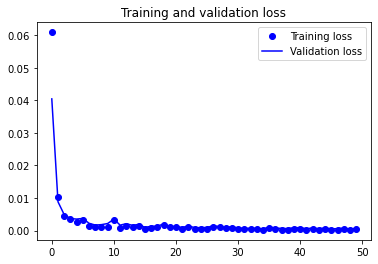

In [10]:
epochs = range(NUM_EPOCHS)
import matplotlib.pyplot as plt

plt.figure()

plt.plot(epochs, training_history['loss'], 'bo', label='Training loss')
plt.plot(epochs, validation_history['loss'], 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

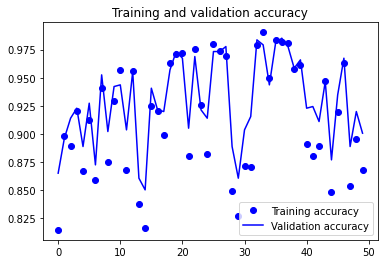

In [11]:
epochs = range(NUM_EPOCHS)
import matplotlib.pyplot as plt

plt.figure()


plt.plot(epochs, training_history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, validation_history['accuracy'], 'b', label='Validation accuracy')
# plt.plot(epochs, state.metrics['loss'], 'r', label='loss')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()